# Plot model predictions for range expansions experiments

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from community import community
matplotlib.rc("figure", figsize=(10,5))

## Load Data and set experimentally measured parameters

In [19]:
#load dictionary with fit parameters from file
with open('fit_parameters.txt', 'r') as file:
    fit_pars = eval(file.read())

#load dictionary with growth rates from file    
with open('growth_rates.txt', 'r') as file:
    growth_rates = eval(file.read())
    
#load dataframe with preprocessing results
df_data = pd.read_csv('community_data_mean.csv')  
  
#rename the data columns to match the prediction columns
columns_data={'Condition': 'community', 
              'Ratio': 'eq freq', 
              'rel_growth': 'relative growth', 
              'rel_range': 'relative range', 
              'dT_patch': 'range dT', 
              'dP_patch': 'range dP'}

df_data = df_data.rename(columns=columns_data)
df_data['relative growth'] = df_data['Width'] / df_data.loc[df_data['community']=='WT']['Width'].values[0]
df_data = df_data[df_data['community'] != 'WT'].reset_index(drop=True)
df_data['source'] = 'data'
df_data.drop('Width',axis=1,inplace=True)    

---

## Predict community properties

In [23]:
  
#specify the parameters for the different communities
par_com_A = {
            'lPro': fit_pars['lPro'], 
            'lTrp': fit_pars['lTrp'], 
            'c_prod_T': 1, 
            'c_prod_P': 1,
            'c_up_P': 1,
            'mu_dP': growth_rates['dP'],
            'mu_dT': growth_rates['dT'],
            }

par_com_B = {
            'lPro': fit_pars['lPro'], 
            'lTrp': fit_pars['lTrp'], 
            'c_prod_T': 1, 
            'c_prod_P': 1,
            'c_up_P': fit_pars['c_up_P'],
            'mu_dP': growth_rates['dP_proUp'],
            'mu_dT': growth_rates['dT'],
            }

par_com_C = {
            'lPro': fit_pars['lPro'], 
            'lTrp': fit_pars['lTrp'], 
            'c_prod_T': fit_pars['c_prod_T'], 
            'c_prod_P': 1,
            'c_up_P': 1,
            'mu_dP': growth_rates['dP_trpOP'],
            'mu_dT': growth_rates['dT'],
            }

par_com_D = {
            'lPro': fit_pars['lPro'], 
            'lTrp': fit_pars['lTrp'], 
            'c_prod_T': fit_pars['c_prod_T'], 
            'c_prod_P': 1,
            'c_up_P': fit_pars['c_up_P'],
            'mu_dP': growth_rates['dP_proUp'], #need to be measured
            'mu_dT': growth_rates['dT'],
            }

par_com_E = {
            'lPro': fit_pars['lPro'], 
            'lTrp': fit_pars['lTrp'], 
            'c_prod_T': 1, 
            'c_prod_P': fit_pars['c_prod_P'],
            'c_up_P': 1,
            'mu_dP': growth_rates['dP'],
            'mu_dT': growth_rates['dT_proOP'],
            }

par_com_F = {
            'lPro': fit_pars['lPro'], 
            'lTrp': fit_pars['lTrp'], 
            'c_prod_T': 1, 
            'c_prod_P': fit_pars['c_prod_P'],
            'c_up_P': fit_pars['c_up_P'],
            'mu_dP': growth_rates['dP_proUp'], 
            'mu_dT': growth_rates['dT_proOP'],
            }


par_com_G = {
            'lPro': fit_pars['lPro'], 
            'lTrp': fit_pars['lTrp'], 
            'c_prod_T': fit_pars['c_prod_T'], 
            'c_prod_P': fit_pars['c_prod_P'],
            'c_up_P': 1,
            'mu_dP': growth_rates['dP_trpOP'],
            'mu_dT': growth_rates['dT_proOP'],
            }

par_com_H = {
            'lPro': fit_pars['lPro'], 
            'lTrp': fit_pars['lTrp'], 
            'c_prod_T': fit_pars['c_up_P'], 
            'c_prod_P': fit_pars['c_prod_P'],
            'c_up_P': fit_pars['c_up_P'],
            'mu_dP': growth_rates['dP_proUp'], #needs to be measured
            'mu_dT': growth_rates['dT_proOP'],
            }

#create a dictionary with the parameters for the different communities
par_coms = {'A': par_com_A, 
            'B': par_com_B, 
            'C': par_com_C, 
            'D': par_com_D, 
            'E': par_com_E,
            'F': par_com_F, 
            'G': par_com_G, 
            'H': par_com_H}    

#run the community model for the different communities
communities = {key: community(mu_WT=growth_rates['WT'], **val) for key, val in par_coms.items()}

#extract the equilibrium properties of the different communities
df_pred = pd.DataFrame()
for key, val in communities.items():
    df_pred.loc[key, 'community'] = key
    df_pred.loc[key, 'source'] = 'prediction'
    df_pred.loc[key, 'eq freq'] = val.eq
    df_pred.loc[key, 'relative growth'] = val.rel_growth_wt
    df_pred.loc[key, 'relative range'] = val.rangeP/val.rangeT
    df_pred.loc[key, 'range dP'] = val.rangeP
    df_pred.loc[key, 'range dT'] = val.rangeT
    
df =  pd.concat([df_data, df_pred]).reset_index(drop=True)

#store the dataframe with the prediction and data
df.to_csv('model_predictions.csv', index=False)

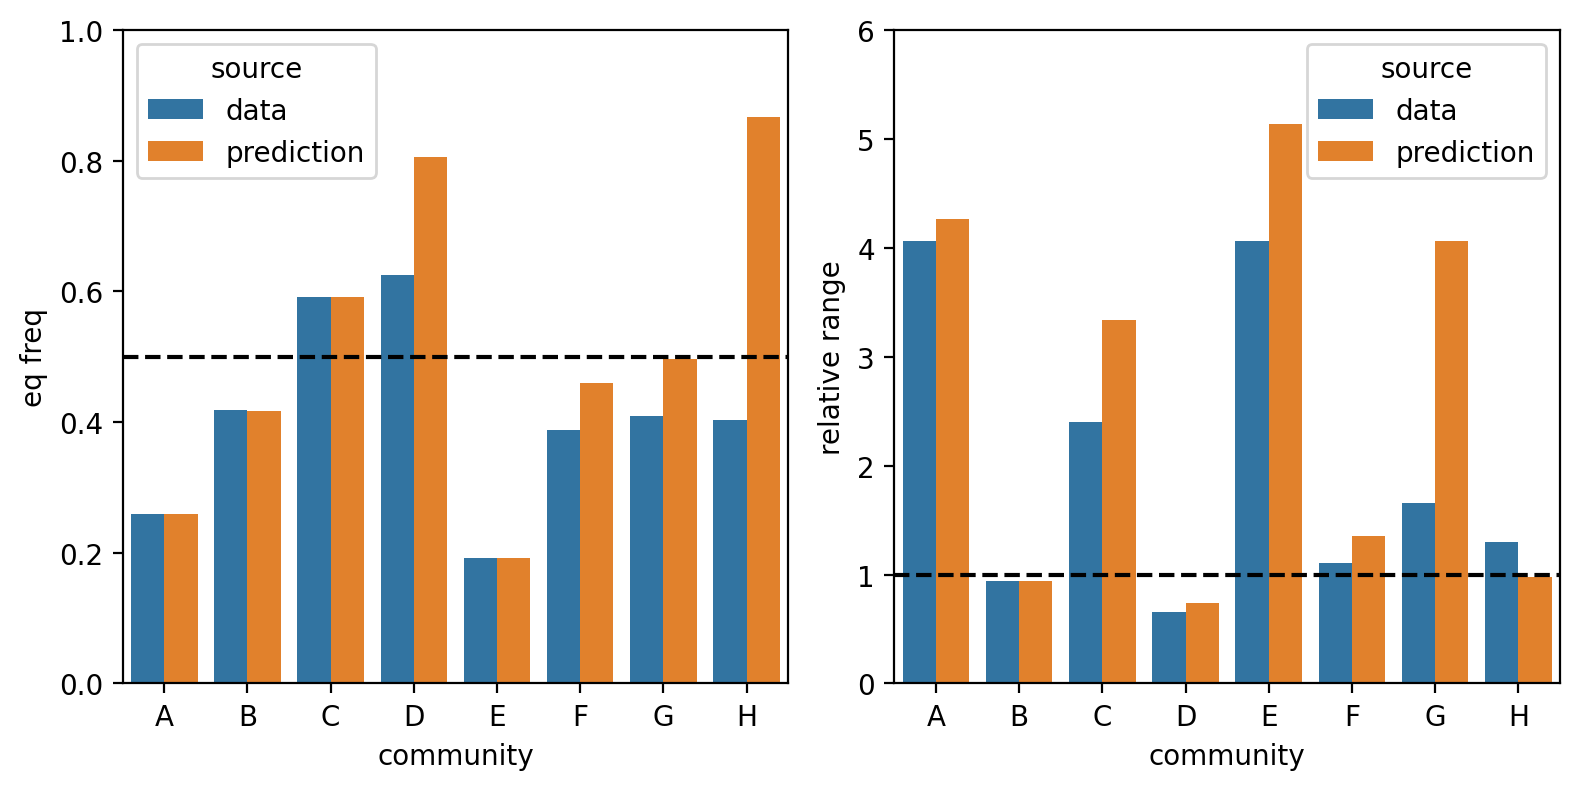

In [24]:
fig, axs = plt.subplots(1,2,figsize=(8,4))

sns.barplot(df, x="community", y="eq freq", hue="source", ax=axs[0])
sns.barplot(df, x="community", y="relative range", hue="source", ax=axs[1])
fig.tight_layout()

# Set max y-axis value for each subplot
axs[0].set_ylim(top=1)  # Set max y-axis value for the first subplot
axs[1].set_ylim(top=6)  # Set max y-axis value for the third subplot

#add dotted vertical reference line
axs[0].axhline(y=0.5, color='k', linestyle='--')
axs[1].axhline(y=1, color='k', linestyle='--')
fig.savefig(f"model_predictions.pdf")

---

### Plot growth profiles for all the communities

In [25]:
def plot_growth_profile(community):
    ''' Plot growth profiles of the community
    
    Parameters:
    community: community object
    
    Returns:
    fig: figure object
    
    '''

    #set colors
    yellow = np.array([246,219,147])/255
    blue = np.array([42,86,152])/255
    
    #calculate growth profiles
    x_vec = np.linspace(0,60,1000)
    community.calc_growth_profiles(x_vec)
    #community.calc_growth_profiles_sectors()
    
    #normalize to WT growth rate
    muWT = community.mu0 * 3600
    
    #plot growth profiles
    fig,ax = plt.subplots(1,1,figsize=(5,5))
    ax.plot(community.x_T, community.mu_profile_T/muWT, color=yellow, label='dT')
    ax.plot(community.x_P, community.mu_profile_P/muWT, color=blue, label='dP')
    
    # ax.plot(community.x_sector_T, community.mu_profile_sector_T/muWT, color=yellow, label='dT sect', linestyle='--')
    # ax.plot(community.x_sector_P, community.mu_profile_sector_P/muWT, color=blue, label='dP sect', linestyle='--')    
    
    ax.set_xlabel('Position (um)')
    ax.set_ylabel('Growth rate relative to WT')
    ax.set_ylim(0,1)
    
    #add reference lines
    plt.axvline(x=0, color='k', linestyle='-')
    plt.axvline(x=community.rangeP, color=blue, linestyle=':')
    plt.axvline(x=-community.rangeT, color=yellow, linestyle=':')

    return fig

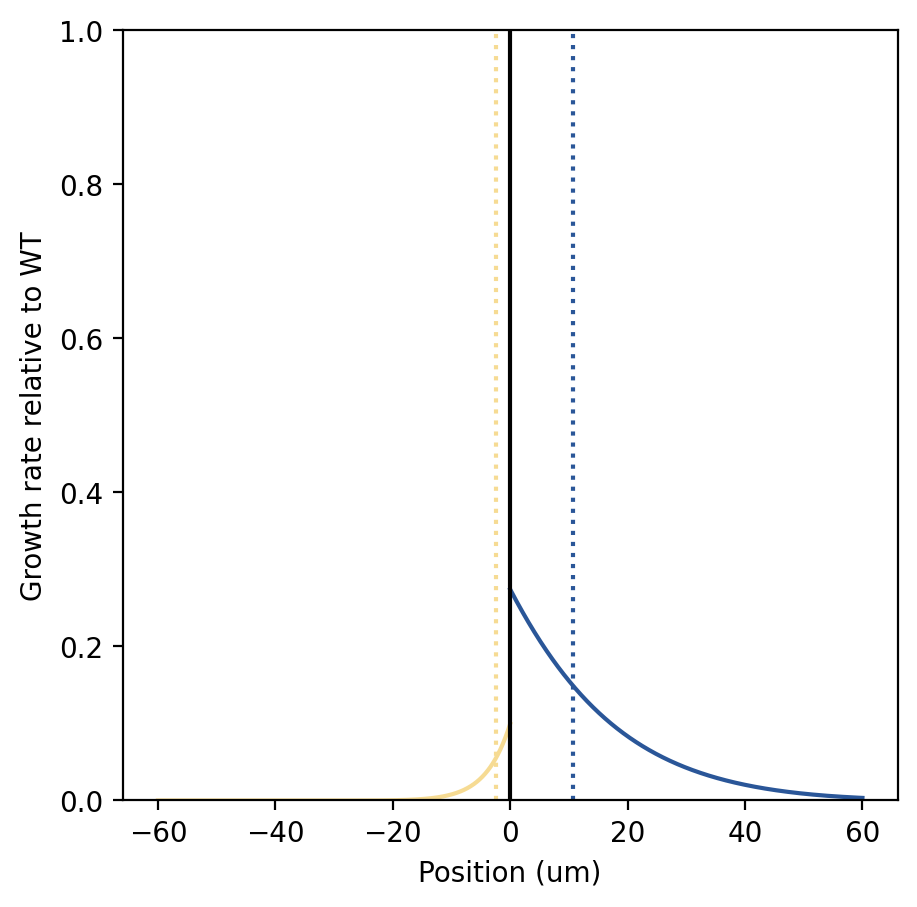

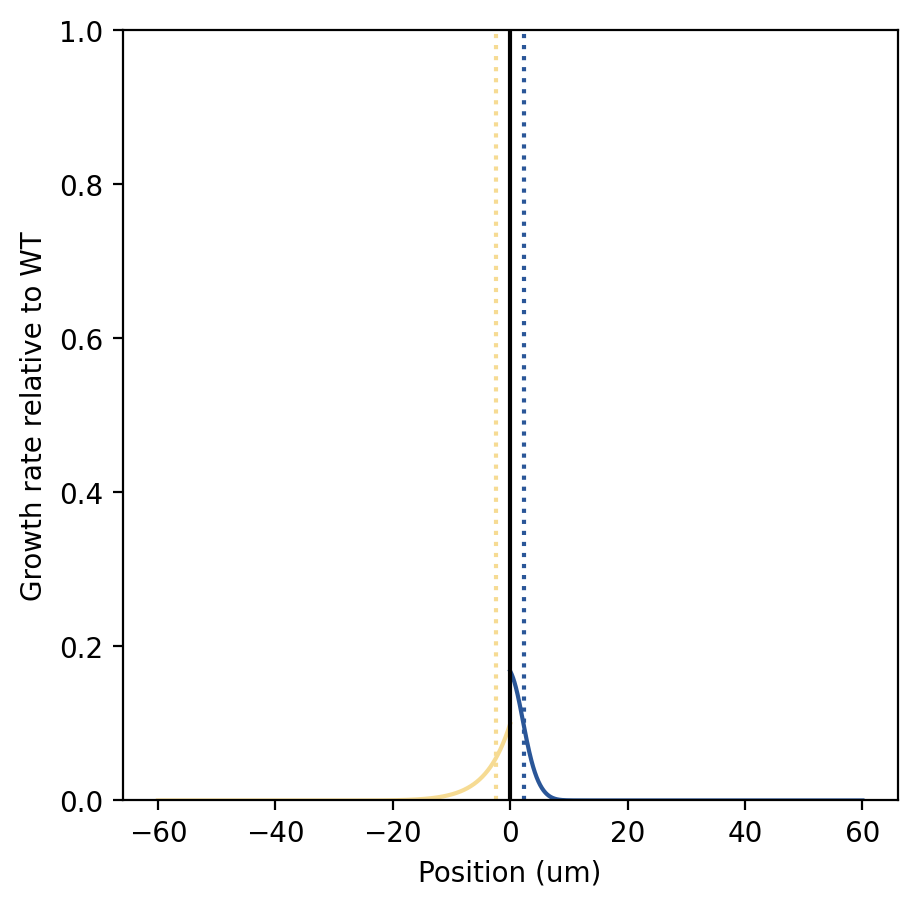

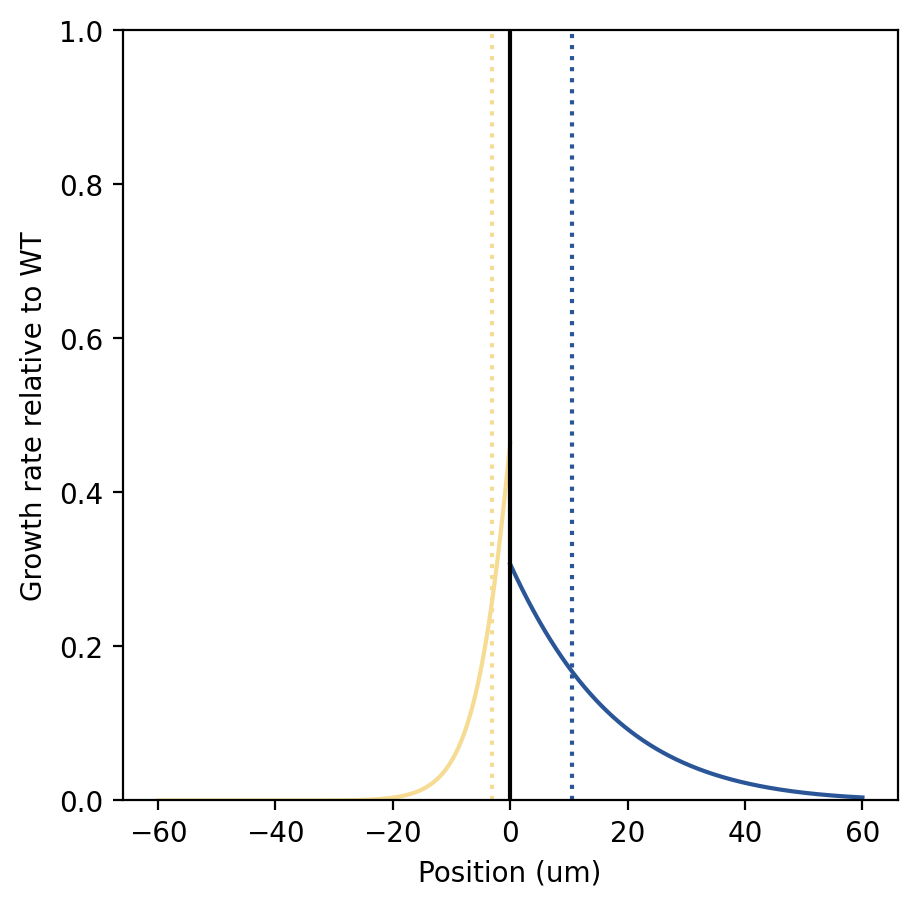

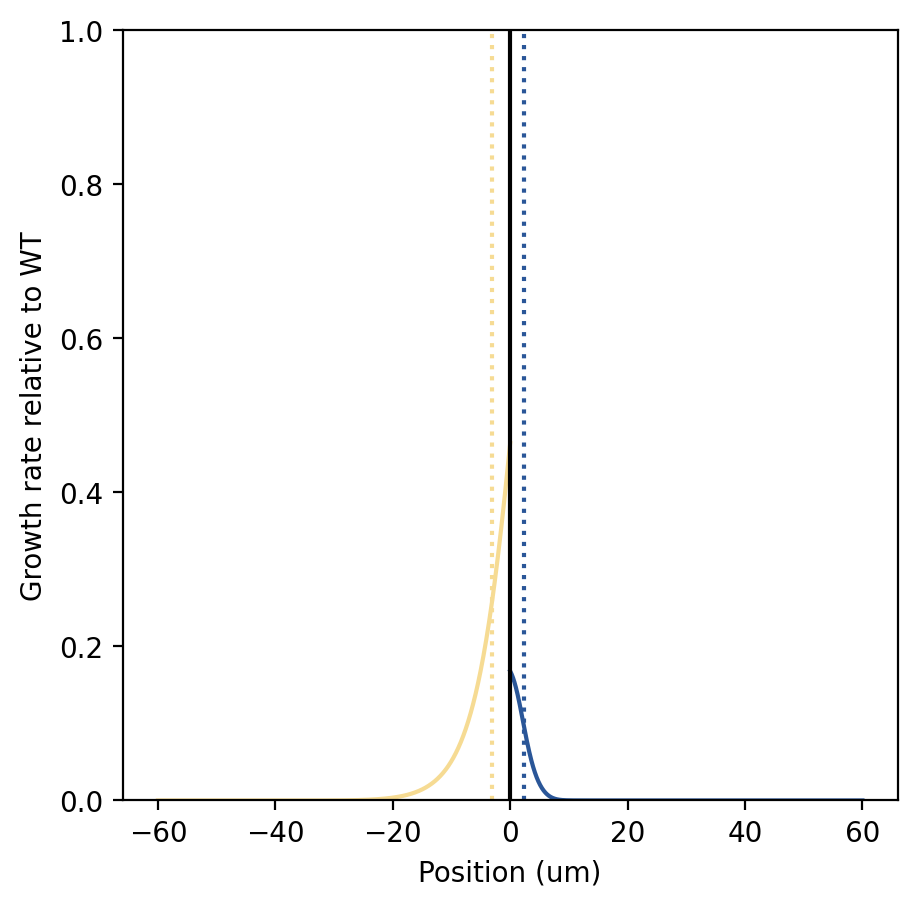

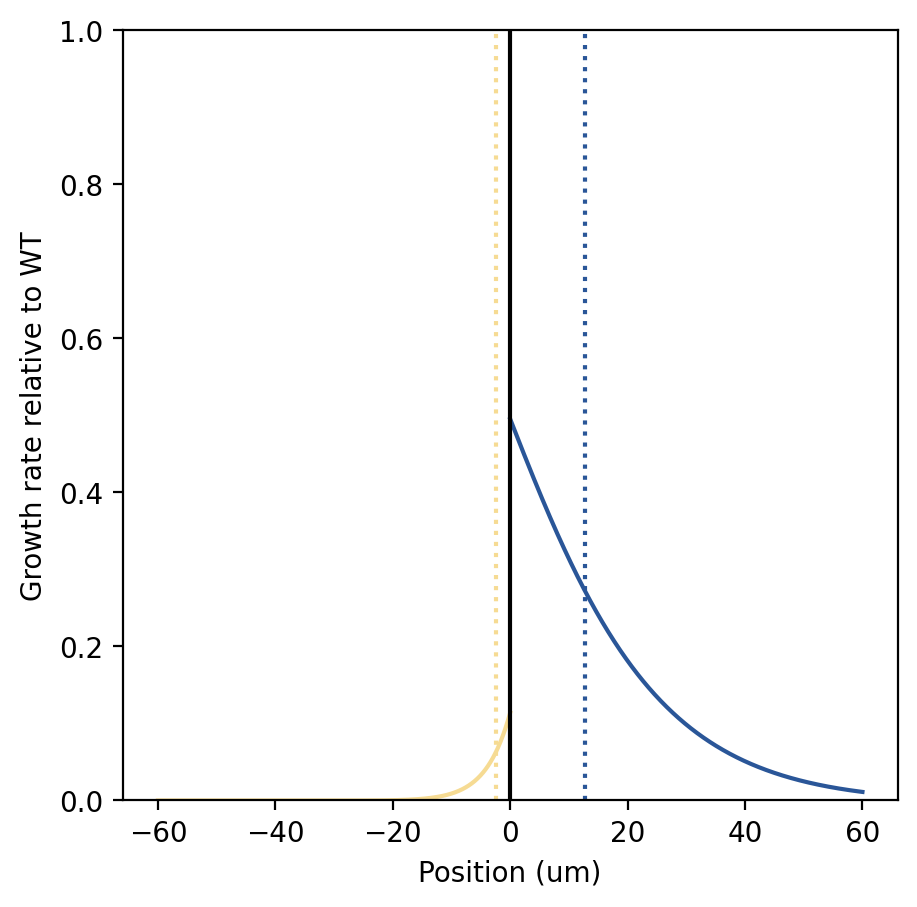

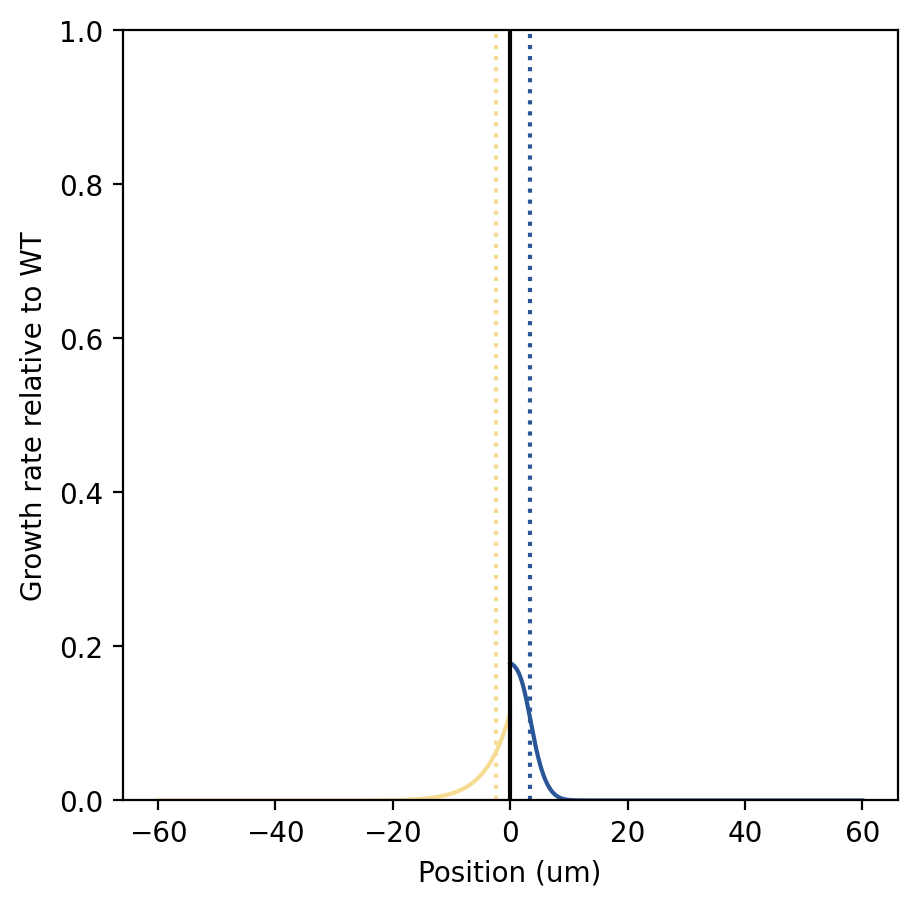

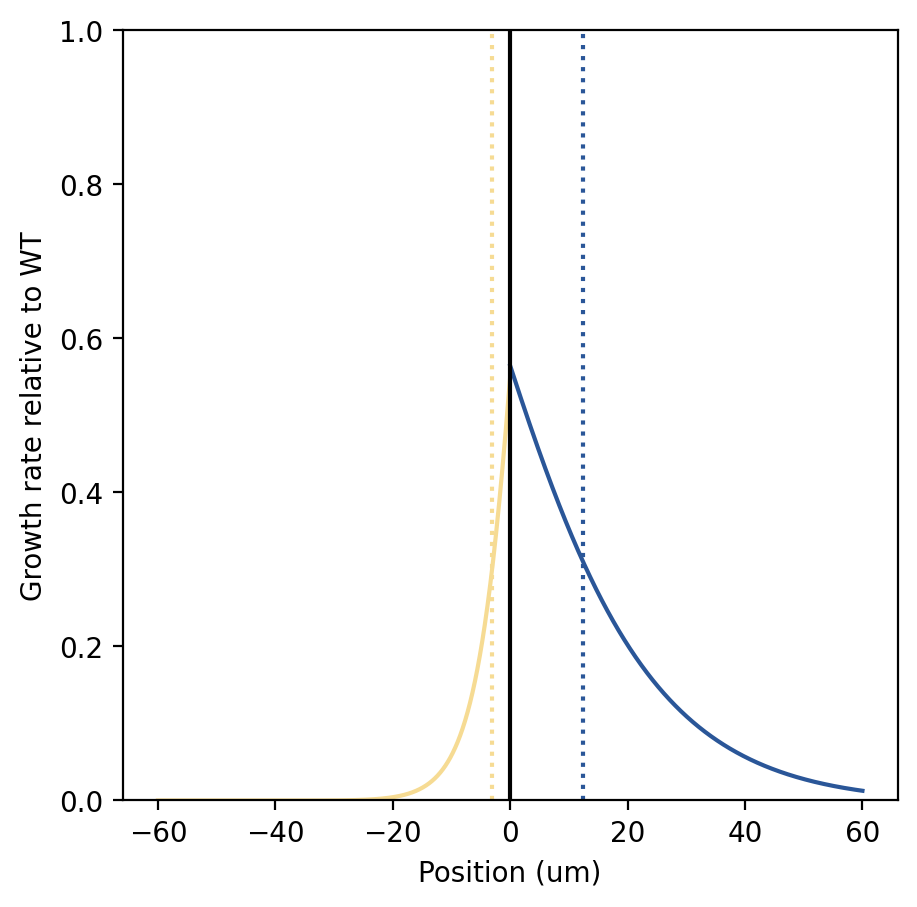

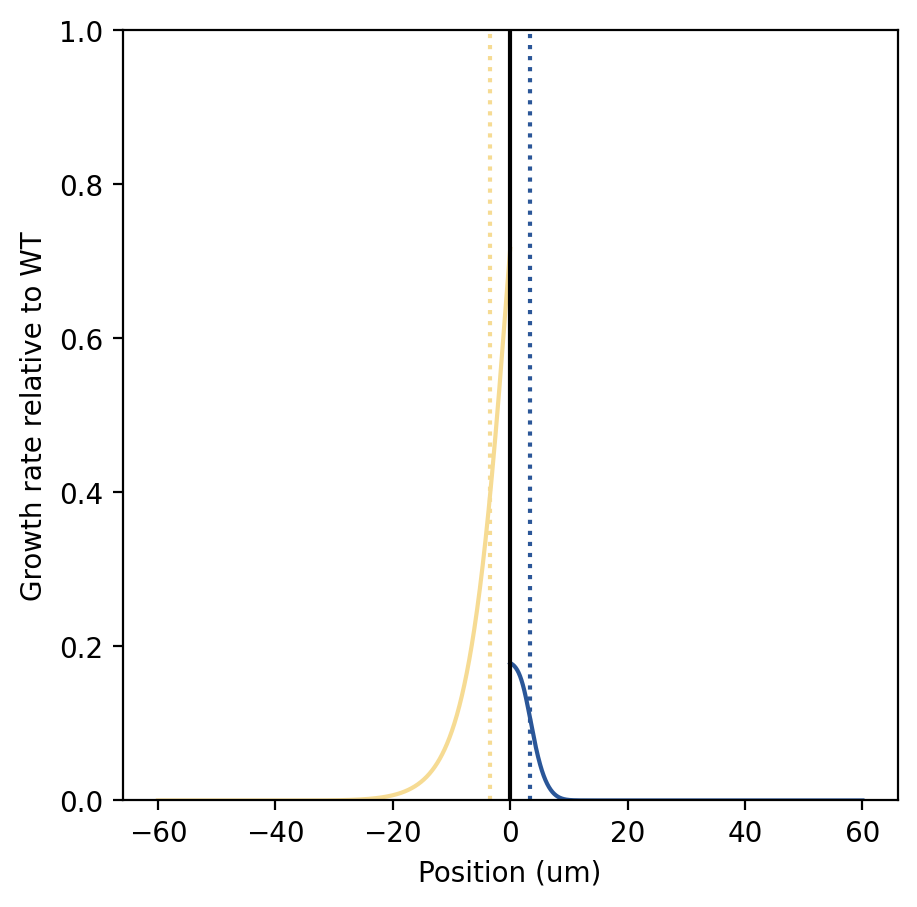

In [26]:
for key, val in communities.items():
    plot_growth_profile(val).savefig(f"growth_profile_community{key}.pdf")

---

## Plot parameter dependence of fitted parameters

In [119]:
def plot_parameter_sensitivity(df_data,x,x_fit,community_fit, community_name, xlabel, xticks, ylim_range=5):
    #add reference lines
    fig,ax = plt.subplots(2,1,figsize=(5,4))

    eq_data = df_data[df_data['community']==community_name]['eq freq'].values[0]
    rel_range_data = df_data[df_data['community']==community_name]['relative range'].values[0]
    ax[0].axhline(y=rel_range_data, color='k', linestyle='--', linewidth=0.5)
    ax[1].axhline(y=eq_data, color='k', linestyle='--', linewidth=0.5)

    ax[0].axvline(x=x_fit, color='k', linestyle='--', linewidth=0.5)
    ax[1].axvline(x=x_fit, color='k', linestyle='--', linewidth=0.5)

    rel_range = community_fit.rangeP/community_fit.rangeT

    ax[0].plot(x, rel_range)
    ax[1].plot(x, community_fit.eq)

    ax[1].set_xlabel(xlabel)
    ax[0].set_ylabel('Relative Range dP/dT')
    ax[1].set_ylabel('frequency dT')


    #set x-ticks
    ax[0].set_xlim(left=1, right=xticks.max())
    ax[1].set_xlim(left=1, right=xticks.max())
    ax[0].set_xticks(xticks)
    ax[1].set_xticks(xticks)
    ax[1].set_yticks([0,0.25,0.5,0.75,1])
    ax[0].set_xticklabels('')

    ax[0].set_ylim(0,ylim_range)
    ax[1].set_ylim(0,1)

    plt.tight_layout()
    return fig

### Community B

We show how increase in pro uptake caused by putP over expression affects relative sector size (range dP / range dT) in community B (dP-pEP17-putP + dT)

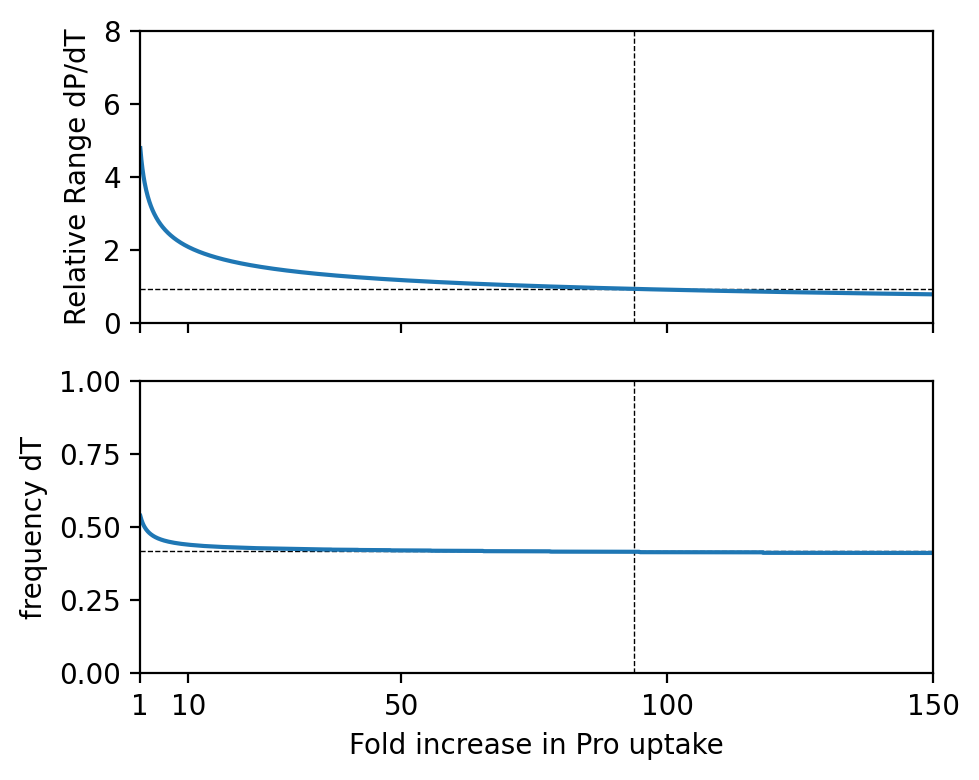

In [132]:
c_up_P = np.arange(1,150.1,0.1)
xticks = np.array([1,10,50,100,150])

par_com_B_var = par_com_B.copy()
par_com_B_var['c_up_P'] = c_up_P

com_B = community(**par_com_B_var)
x_fit = fit_pars['c_up_P']

fig = plot_parameter_sensitivity(df_data,c_up_P, x_fit, com_B, 'B', 'Fold increase in Pro uptake', xticks, ylim_range=8)
fig.savefig(f"parameter_sensitivity_communityB_proUptake.pdf")

### Community C

We fit increase in trp leakage caused by trpR deletion by fitting model to equilibrium fraction of community C (dT + dP-trpR)

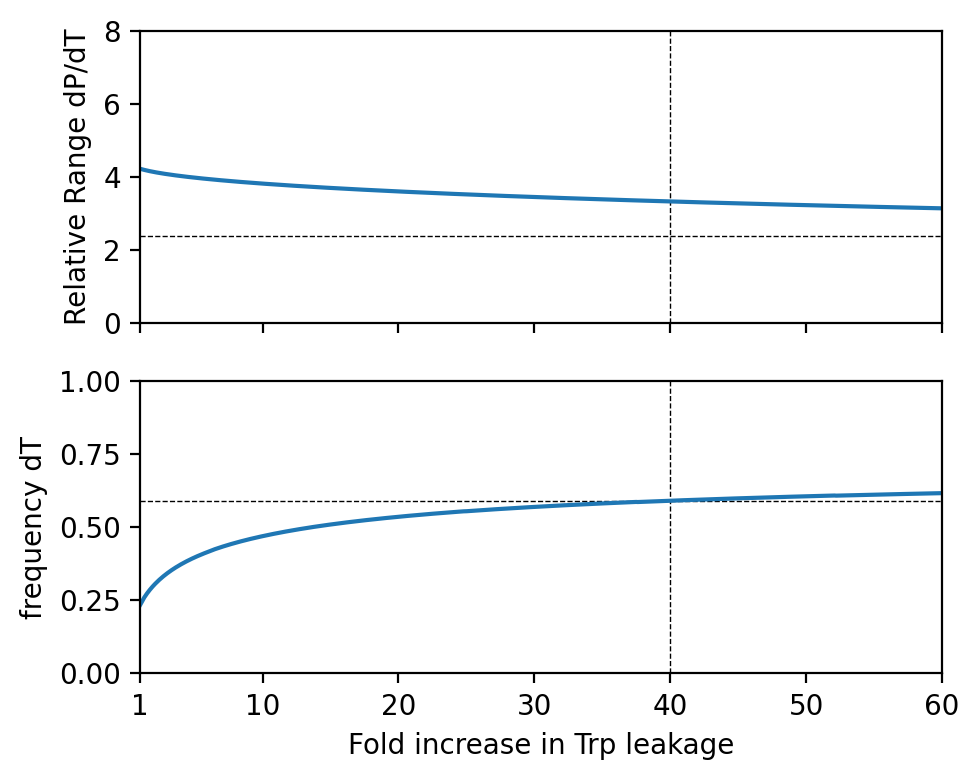

In [131]:
c_prod_T = np.arange(1,60.1,0.1)
xticks = np.array([1,10,20,30, 40, 50, 60])

par_com_C_var = par_com_C.copy()
par_com_C_var['c_prod_T'] = c_prod_T

com_C = community(**par_com_C_var)
x_fit = fit_pars['c_prod_T']

fig = plot_parameter_sensitivity(df_data,c_prod_T, x_fit,com_C, 'C', 'Fold increase in Trp leakage', xticks, ylim_range=8)
fig.savefig(f"parameter_sensitivity_communityC_trpLeakage.pdf")


### Community E

We fit increase in pro leakage caused by proB74 mutation by fitting model to equilibrium fraction of community E (dT-proB74 + dP)

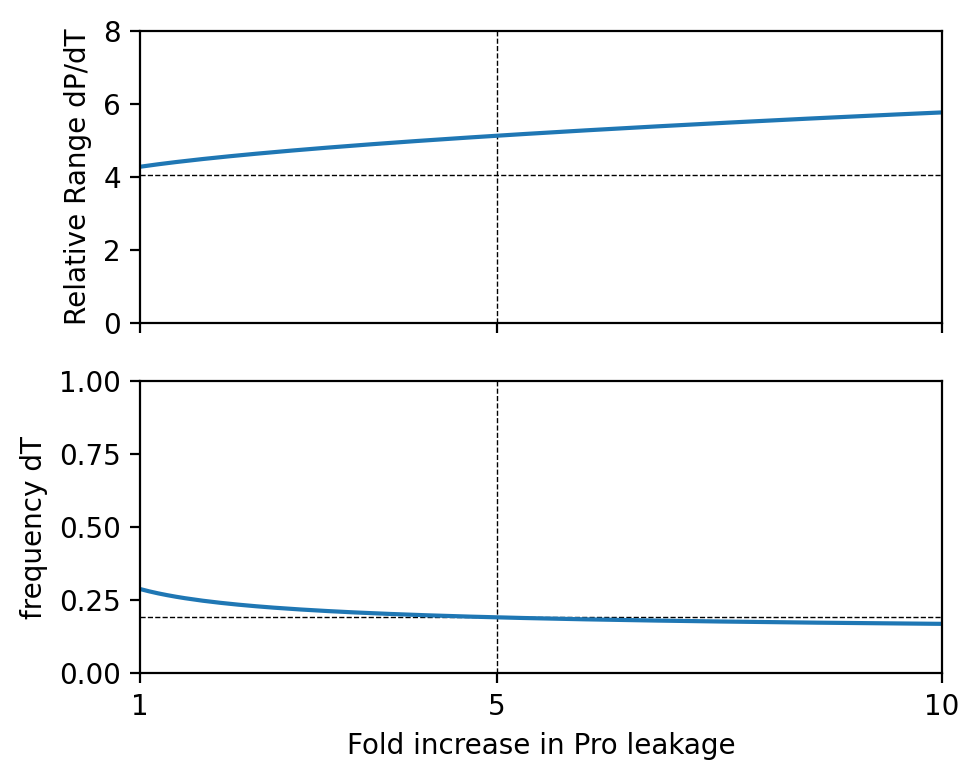

In [130]:
c_prod_P = np.arange(1,60.1,0.1)
xticks = np.array([1,5,10])

par_com_E_var = par_com_E.copy()
par_com_E_var['c_prod_P'] = c_prod_P

com_E = community(**par_com_E_var)
x_fit = fit_pars['c_prod_P']

fig = plot_parameter_sensitivity(df_data,c_prod_P, x_fit,com_E, 'E', 'Fold increase in Pro leakage', xticks, ylim_range=8)
fig.savefig(f"parameter_sensitivity_communityE_proLeakage.pdf")